# Gaussian Process Regression on a Mesh with **GPflow**

This notebooks shows how to fit a [GPflow](https://www.gpflow.org/) Gaussian process (GP) on a mesh.

In [1]:
# Import a backend, we use gpflow in this example.
import tensorflow as tf
import gpflow

# Import the geometric_kernels backend.
import geometric_kernels
import geometric_kernels.tensorflow

# Import the Mesh space and the general-purpose MaternGeometricKernel
from geometric_kernels.spaces.mesh import Mesh
from geometric_kernels.kernels import MaternGeometricKernel

# The GPflow frontend of GeometricKernels
from geometric_kernels.frontends.tensorflow.gpflow import DefaultFloatZeroMeanFunction, GPflowGeometricKernel

# Sampling routines we will use to create a dummy dataset
from geometric_kernels.kernels import default_feature_map
from geometric_kernels.sampling import sampler
from geometric_kernels.utils.utils import make_deterministic

# Stuff
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

/Users/vabor112/Workspace/GeometricKernels/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
INFO: Using numpy backend


## Mesh Plotting Utils for `plotly`

In [2]:
def update_figure(fig):
    """Utility to clean up figure"""
    fig.update_layout(scene_aspectmode="cube")
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
    # fig.update_traces(showscale=False, hoverinfo="none")
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False, showticklabels=False, visible=False),
            yaxis=dict(showbackground=False, showticklabels=False, visible=False),
            zaxis=dict(showbackground=False, showticklabels=False, visible=False),
        )
    )
    return fig

def plot_mesh(mesh: Mesh, vertices_colors = None, **kwargs):
    plot = go.Mesh3d(
        x=mesh.vertices[:, 0],
        y=mesh.vertices[:, 1],
        z=mesh.vertices[:, 2],
        i=mesh.faces[:, 0],
        j=mesh.faces[:, 1],
        k=mesh.faces[:, 2],
        colorscale='viridis',
        intensity=vertices_colors,
        **kwargs
    )
    return plot

## Defining a Space

First, we create a GeometricKernels space that corresponds to a teddy bear mesh loaded from "../data/teddy.obj"

In [3]:
mesh = Mesh.load_mesh(str(Path.cwd().parent / "data" / "teddy.obj"))
print("Number of vertices in the mesh:", mesh.num_vertices)

Number of vertices in the mesh: 1598


Now we actually visualize the mesh.

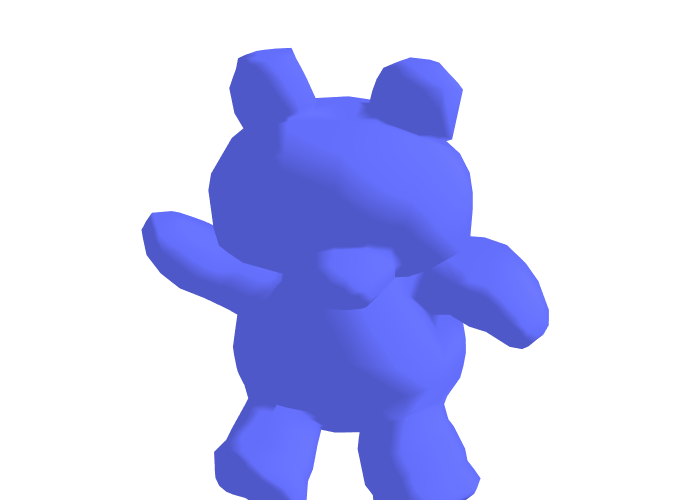

In [4]:
# Define the camera
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0.7, z=1.25)
)

plot = plot_mesh(mesh)
fig = go.Figure(plot)
update_figure(fig)
fig.update_layout(
    scene_camera=camera
)
fig.show('png')

## Create a Dummy Dataset on the Mesh

We sample from the prior of a GP to create a simple dataset we can afterwards fit using an exact Gaussian process regression (GPR) model.

The input set $X \in \mathbb{N}^{n \times 1}$ consists of **indices** enumerating vertices of the mesh. Consequently, the elements of $X$ are in $[0, N_v-1]$, where $N_v$ are the number of vertices in the mesh.
We sample `num_data` of them into the tensor called `xs_train`. For test inputs `xs_test`, we use the whole $X$.

In [5]:
num_data = 25
key = tf.random.Generator.from_seed(1234)

xs_train = key.uniform(shape=(num_data, 1), minval=0, maxval=mesh.num_vertices, dtype=tf.int64)
xs_test = tf.range(mesh.num_vertices, dtype=tf.int64)[:, None]
print('xs_train:', xs_train)
# print('xs_test:', xs_test)

xs_train: tf.Tensor(
[[1575]
 [ 736]
 [ 351]
 [1276]
 [1423]
 [1539]
 [1313]
 [1204]
 [ 728]
 [1451]
 [ 889]
 [  63]
 [  70]
 [ 543]
 [ 267]
 [1194]
 [1540]
 [ 882]
 [1416]
 [ 120]
 [1372]
 [1339]
 [ 200]
 [ 488]
 [ 451]], shape=(25, 1), dtype=int64)


To generate the corresponding outputs `ys_train` and `ys_test`, we sample from the prior. To do this, we create a `MaternGeometricKernel` object and use the efficent sampling functionality of GeometricKernels.

In [6]:
base_kernel = MaternGeometricKernel(mesh)

params = base_kernel.init_params()
params["lengthscale"] = tf.convert_to_tensor([2.0], dtype=tf.float64)
params["nu"]  = tf.convert_to_tensor([2.5], dtype=tf.float64)

feature_map = default_feature_map(kernel=base_kernel)
sample_paths = make_deterministic(sampler(feature_map), key)

_, ys_train  = sample_paths(xs_train, params)
key, ys_test = sample_paths(xs_test,  params)
assert(tf.math.reduce_all(tf.equal(tf.gather(ys_test, xs_train)[:, :, 0], ys_train)))

# print('ys_train:', ys_train)
# print(tf.gather(ys_test, xs_train)[:, :, 0])

/Users/vabor112/Workspace/GeometricKernels/venv/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:347: BeartypeDecorHintPep585DeprecationWarning:

PEP 484 type hint typing.List deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations



## Build a GPflow Model

Now we wrap the `base_kernel` created above into the `GPflowGeometricKernel` to make an actual GPflow kernel.


**Note:** `params` are external to the `base_kernel` object, thus we need to pass them to the `GPflowGeometricKernel` explicitly.
Otherwise it will use `params = base_kernel.init_params()`. The `trainable_nu` parameter changes whether to treat the smoothness parameter `"nu"` as trainable or fixed. `trainable_nu = True` only works for finite values of `"nu"`, it is incompatible with ``nu = inf``.

In [7]:
kernel = GPflowGeometricKernel(base_kernel, nu = params["nu"],
                               lengthscale=params["lengthscale"],
                               variance=1.0,
                               trainable_nu=False)

We use the data `xs_train`, `ys_train` and the GPflow kernel `kernel` to construct a GPflow model.

**Note:** We use `DefaultFloatZeroMeanFunction` mean: the `ZeroMeanFunction` that GPflow uses by default sets the output dtype equal to the input's dtype, while `DefaultFloatZeroMeanFunction` sets it to `default_float` instead.

In [8]:
model = gpflow.models.GPR(
    (xs_train, ys_train), kernel, mean_function=DefaultFloatZeroMeanFunction(), noise_variance=1e-4
)

from gpflow.utilities import print_summary
print('Initial model:')
print('kernel.nu = ', kernel.nu)
print_summary(model)
print("Initial negative log marginal likelihood:", -model.log_marginal_likelihood().numpy())

Initial model:
kernel.nu =  tf.Tensor([2.5], shape=(1,), dtype=float64)
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value   │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [2.]    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0001  │
╘═══════════════════════

## Train the Model (Optimize Hyperparameters)

In [9]:
opt = gpflow.optimizers.Scipy()

print('Starting training...')
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))
print('Final model:')
print_summary(model)
print("Final negative log marginal likelihood:", -model.log_marginal_likelihood().numpy())

Starting training...
Cause: Unable to locate the source code of <function __beartype_tester_8 at 0x2f0a6cd30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_8 at 0x2f0a6cd30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_8 at 0x2f0a6cd30>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_9 at 0x2f0a6cdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the functi

Cause: Unable to locate the source code of <function __beartype_tester_9 at 0x2f0a6cdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_9 at 0x2f0a6cdc0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_10 at 0x2f0a6ce50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the funct

Cause: Unable to locate the source code of <function __beartype_tester_10 at 0x2f0a6ce50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_10 at 0x2f0a6ce50>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_11 at 0x2f0a6cee0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_11 at 0x2f0a6cee0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_11 at 0x2f0a6cee0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_16 at 0x2dbc961f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_16 at 0x2dbc961f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_16 at 0x2dbc961f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_17 at 0x2dbc96280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_17 at 0x2dbc96280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_17 at 0x2dbc96280>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_13 at 0x2dbc96040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_13 at 0x2dbc96040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_13 at 0x2dbc96040>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_18 at 0x2dbc96310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_18 at 0x2dbc96310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_18 at 0x2dbc96310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_19 at 0x2dbc963a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_19 at 0x2dbc963a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_19 at 0x2dbc963a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_20 at 0x2dbc96430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_20 at 0x2dbc96430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_20 at 0x2dbc96430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_21 at 0x2dbc964c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_21 at 0x2dbc964c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_21 at 0x2dbc964c0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_12 at 0x2f0a6cf70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_12 at 0x2f0a6cf70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_12 at 0x2f0a6cf70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_14 at 0x2dbc960d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_14 at 0x2dbc960d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_14 at 0x2dbc960d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_15 at 0x2dbc96160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_15 at 0x2dbc96160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_15 at 0x2dbc96160>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'type_from' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'type_from' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'type_from' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'type_from' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'type_from' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: name 'type_from' is not defined
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_31 at 0x2dbc63b80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_31 at 0x2dbc63b80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_31 at 0x2dbc63b80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_25 at 0x2dbc96790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_25 at 0x2dbc96790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_25 at 0x2dbc96790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_26 at 0x2dbc96820>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_26 at 0x2dbc96820>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_26 at 0x2dbc96820>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function __beartype_tester_27 at 0x2dbc96940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the func

Cause: Unable to locate the source code of <function __beartype_tester_27 at 0x2dbc96940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function __beartype_tester_27 at 0x2dbc96940>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Final model:
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value     │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [2.47975] │
├

## Draw Predictions and Evaluate the Model

Recall that `xs_test` contains all the locations on the mesh, i.e. all numbers from the set $\{0, 1, \ldots, N_v-1\}$.

In [10]:
# predict mean and variance
posterior_mean, posterior_variance = model.predict_f(xs_test)
posterior_mean = posterior_mean.numpy()
posterior_std = np.sqrt(posterior_variance.numpy())

# predict sample
sample = model.predict_f_samples(xs_test).numpy()

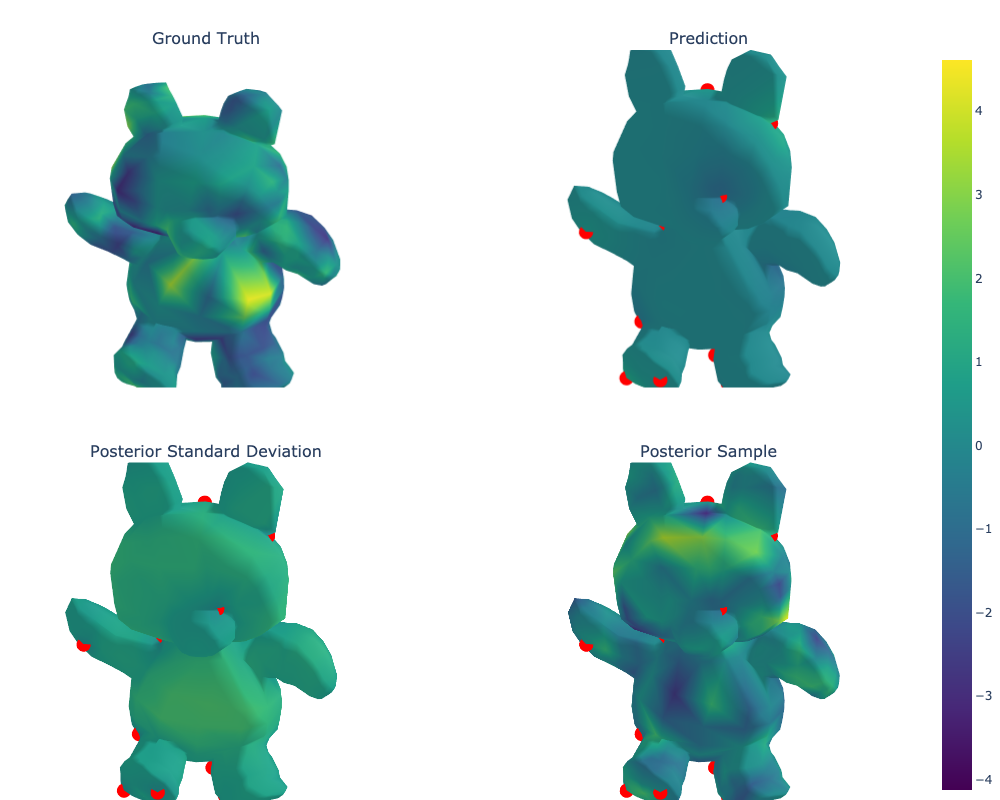

In [11]:
# Mark training data
training_data_coords = tf.gather(mesh.vertices, xs_train[:, 0])

training_data_plot  = go.Scatter3d(
    x=np.array(training_data_coords[:, 0]),
    y=np.array(training_data_coords[:, 1]),
    z=np.array(training_data_coords[:, 2]),
    mode = 'markers',
    marker_color = 'red',
    name=''
)

# Various plots as plotly traces
ground_truth_plot   = plot_mesh(mesh, vertices_colors=ys_test,        coloraxis = "coloraxis")
posterior_mean_plot = plot_mesh(mesh, vertices_colors=posterior_mean, coloraxis = "coloraxis")
posterior_std_plot  = plot_mesh(mesh, vertices_colors=posterior_std,  coloraxis = "coloraxis")
sample_plot         = plot_mesh(mesh, vertices_colors=sample,         coloraxis = "coloraxis")

# Setting up the layout
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=(r"Ground Truth",
                    r"Prediction",
                    r"Posterior Standard Deviation",
                    r"Posterior Sample"),
    vertical_spacing=0.1)

# Adding the traces
fig.add_trace(ground_truth_plot,   row=1, col=1)

fig.add_trace(training_data_plot,  row=1, col=2)
fig.add_trace(posterior_mean_plot, row=1, col=2)

fig.add_trace(training_data_plot,  row=2, col=1)
fig.add_trace(posterior_std_plot,  row=2, col=1)

fig.add_trace(training_data_plot,  row=2, col=2)
fig.add_trace(sample_plot,         row=2, col=2)

fig = update_figure(fig)

fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera
fig.layout.scene4.camera = camera


fig.update_layout(
    margin={'t': 50},
    coloraxis = {'colorscale':'viridis'},
)

fig.show('png', width=1000, height=800)